In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

sns.set_style("whitegrid")

In [2]:
# Define a function to convert the dates into a readable format and prepare it for datetime conversion
def fix_date_format(date):
    '''Changes format from DD.MM.YYYY to YYYY-MM-DD'''
    return (date[-4:] + '-' + date[3:5] + '-' + date[:2])

In [3]:
# Import the training data
training_df = pd.read_csv('sales_train_v2.csv')

# Import the items dataset
items_df = pd.read_csv('items.csv')

# Import the item_categories.csv dataset with the item_category_id as the index
items_cat_df = pd.read_csv('item_categories.csv', index_col = 'item_category_id')

# Import the shops.csv dataset with the shop_id as the index
shops_df = pd.read_csv('shops.csv', index_col = 'shop_id')

# Import the test.csv dataset with the ID as the index
test = pd.read_csv('test.csv', index_col = 'ID')

# Import the sample_submission.csv dataset with the ID as the index
sample = pd.read_csv('sample_submission.csv', index_col = 'ID')

In [4]:
# Convert the date column to a datetime object.
training_df['date'] = training_df['date'].apply(fix_date_format)
datetime_conversion = pd.to_datetime(training_df['date'])
training_df['date'] = datetime_conversion

In [5]:
# Remove outliers in the item_price from our dataset.
training_df = training_df[(training_df['item_price'] != 307980.0) & (training_df['item_price'] >= 0)]

# Create another dataset with all negative values in item_cnt_day removed in case we want to use it.
no_negative_df = training_df[training_df['item_cnt_day'] >= 0]

First, we'll work with our training_df (with negative values in the item_cnt_day).

In [6]:
# Since we're excluding the item category and shop names, we only need two datasets: training_df and items_df
training_merge_df = training_df.merge(items_df, on='item_id')

# We'll also remove the item_name column here.
training_merge_df.drop('item_name', axis=1, inplace=True)

In [7]:
# For later analysis, we may want to use only the month or month + year for analysis (provides cylical data)
# We'll make new columns here for both the month and year.

training_merge_df['month'] = training_merge_df['date'].dt.month
training_merge_df['year'] = training_merge_df['date'].dt.year

In [8]:
# Since we have entries with dates, we'll go ahead and a time series plot with it.
# We'll construct plots for 3 random shops to check for performance and also plot the mean of them.

# First we need to construct a list to define our x-axis
x_label = '2013-01 2013-05 2013-09 2014-01 2014-05 2014-09 2015-01 2015-05 2015-09'.split(' ')

# First Plot: shop_id = 10
shop_10 = training_merge_df[training_merge_df['shop_id'] == 10].groupby('date')['item_cnt_day'].sum()
resamp_10 = shop_10.resample('M', label='left').sum()

# Second Plot: shop_id = 24
shop_24 = training_merge_df[training_merge_df['shop_id'] == 24].groupby('date')['item_cnt_day'].sum()
resamp_24 = shop_24.resample('M', label='left').sum()

# Third Plot: shop_id = 50
shop_50 = training_merge_df[training_merge_df['shop_id'] == 50].groupby('date')['item_cnt_day'].sum()
resamp_50 = shop_50.resample('M', label='left').sum()

# Mean Plot:
combined_shops = pd.DataFrame([resamp_10, resamp_24, resamp_50]).T
combined_shops.columns = ['shop_10', 'shop_24', 'shop_50']
combined_shops['average'] = combined_shops.mean(axis=1)

Text(0.5,1,'Total items sold monthly')

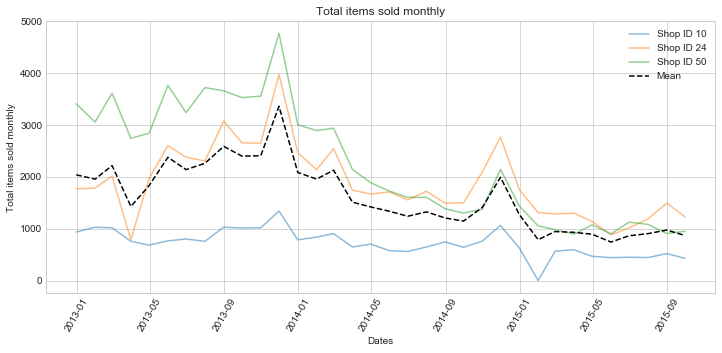

In [9]:
# Plot all three plots and the mean plot on one figure 
plt.figure(figsize=(12, 5))

plt.plot(resamp_10, alpha=0.5)
plt.plot(resamp_24, alpha=0.5)
plt.plot(resamp_50, alpha=0.5)
plt.plot(combined_shops['average'], c='black', linestyle='--')

plt.legend(['Shop ID 10', 'Shop ID 24', 'Shop ID 50', 'Mean'])
plt.xticks(rotation=60)
plt.xticks(x_label)

plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Total items sold monthly')

Some things to takeaway from this plot is that overall sales are declining over time (2013 > 2014 > 2015 > ...). However, there is a reoccuring peak at December for both years. This indicates there is likely a seasonal event that promotes sales around that. I also appears that, in general, all stores follow this trend.

Text(0.5,1,'Total items sold across all shops per month')

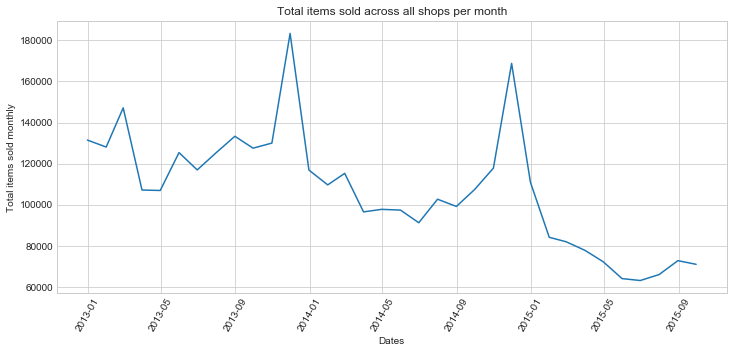

In [10]:
# We'll go ahead and plot the total sales of all the shops next to observe the trend.

# Let's define the dataframe for the plot here
sum_shops_df = training_merge_df.groupby('date')['item_cnt_day'].sum().resample('M', label='left').sum()

# Plot the data
plt.figure(figsize=(12,5))
plt.plot(sum_shops_df)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Total items sold across all shops per month')

Text(0.5,1,'Average items sold monthly')

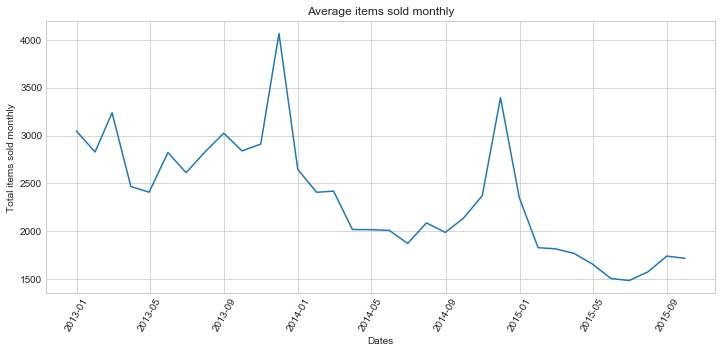

In [11]:
# We'll also plot the mean sales of all the shops

# Let's define the dataframe for the mean sales here
mean_shops_df = training_merge_df.groupby(['date', 'shop_id'])['item_cnt_day'].sum()
mean_shops_df = mean_shops_df.groupby('date').mean().resample('M', label='left').sum()

# Plot the data
plt.figure(figsize=(12,5))
plt.plot(mean_shops_df)
plt.xticks(rotation=60)
plt.xticks(x_label)
plt.xlabel('Dates')
plt.ylabel('Total items sold monthly')
plt.title('Average items sold monthly')

It looks like the plots with all shops supports that sales have declined over the years, but there are still peaked sales on December.

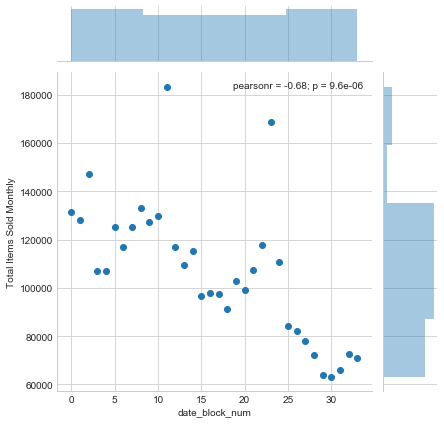

In [20]:
# Since our target variable will be item_cnt_day (or rather item_cnt_month since we'll be working with monthly data), we'll
# plot jointplots and barplots to observe the correlation between item_cnt_month with a multitude of other variables.
# We'll also be using histograms to observe the distribution of the sales


# First we'll check out a general progression sales with time using date_block_num

# Define the dataframe
date_block_df = training_merge_df.groupby('date_block_num')[['item_cnt_day']].sum()
date_block_df.columns = ['Total Items Sold Monthly']

# Plot the jointplot
sns.jointplot(x=date_block_df.index, y=date_block_df['Total Items Sold Monthly'], kind = 'scatter')

Text(0,0.5,'Frequency')

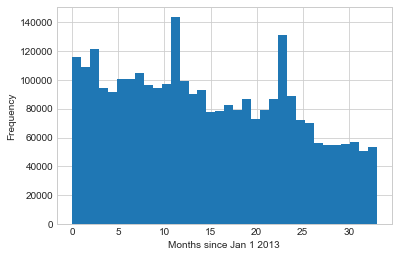

In [21]:
# Plot the histogram
plt.hist(training_merge_df['date_block_num'],bins=34)
plt.xlabel('Months since Jan 1 2013')
plt.ylabel('Frequency')

# From the histogram, we see similar patterns to the time-series plots from before

Text(0,0.5,'Frequency')

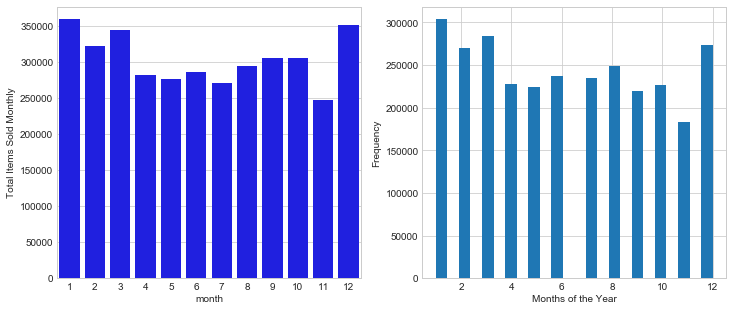

In [24]:
# Next let's take a look at the months. This will give us a bettr idea of cyclical patterns.
month_df = training_merge_df.groupby('month')[['item_cnt_day']].sum()
month_df.columns = ['Total Items Sold Monthly']

# Define the subplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the barplot
sns.barplot(x=month_df.index, y=month_df['Total Items Sold Monthly'], color='b', ax=ax1)

# Plot the histogram
ax2.hist(training_merge_df['month'], bins=24)
ax2.set_xlabel("Months of the Year")
ax2.set_ylabel("Frequency")

# Note: I used 24 bins so that there are distinct divisions in the plot so it's easier to observe

# It appears that the bar plot and histogram can be misleading. Our data only goes up to Oct 2015, which means
# that there is no data for months 11 and 12. This causes a huge drop in value for these two months.

Text(0,0.5,'Frequency')

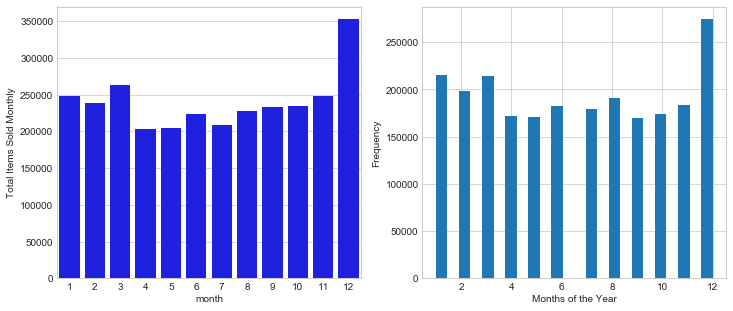

In [29]:
# Since the two previous plots are misleading, I will redo the plots with data between 2013-2014.

# Let's make a new dataset here
month_cut_df = training_merge_df[training_merge_df['year'] != 2015].groupby('month')[['item_cnt_day']].sum()
month_cut_df.columns = ['Total Items Sold Monthly']

# Define the subplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the barplot
sns.barplot(x=month_cut_df.index, y=month_cut_df['Total Items Sold Monthly'], color='b', ax=ax1)

# Plot the histogram
ax2.hist(training_merge_df[training_merge_df['year'] != 2015]['month'],bins=24)
ax2.set_xlabel('Months of the Year')
ax2.set_ylabel('Frequency')

# From this, we can see that December has far more purchases (number of entries and number of items bought per entry)
# Other than that, there doesn't appear to be a drastic decline in number of entries throughout the year (histogram),
# but there is a significant total number of items bought (less items per entry)(jointplot)

Text(0,0.5,'Frequency')

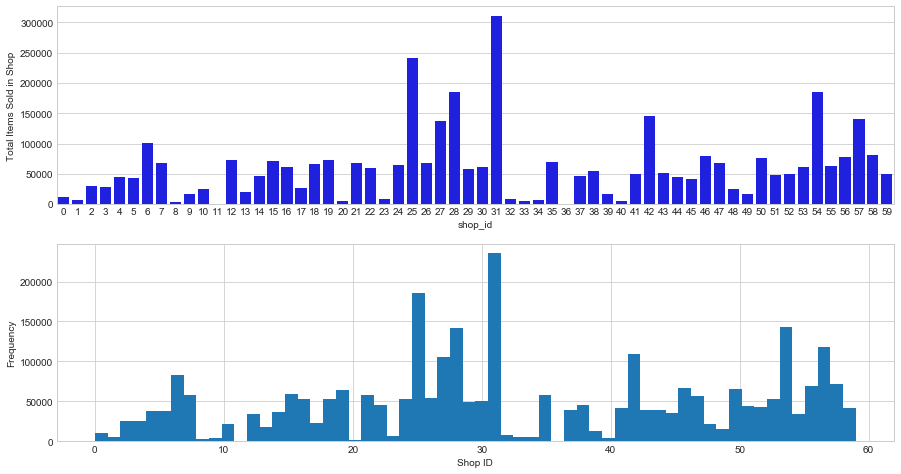

In [34]:
# Next we'll take a look at shop performance.
shop_id_df = training_merge_df.groupby('shop_id')[['item_cnt_day']].sum()
shop_id_df.columns = ['Total Items Sold in Shop']

# Define the subplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 8))

# Plot the barplot
sns.barplot(x=shop_id_df.index, y=shop_id_df['Total Items Sold in Shop'], color='b', ax=ax1)

# Plot the histogram
ax2.hist(x=training_merge_df['shop_id'], bins=60)
ax2.set_xlabel('Shop ID')
ax2.set_ylabel('Frequency')

# From the looks of the data, (in the span of the 2 years) some shops performed significantly better than others.
# However, we don't have to worry about this as we'll be addressing this with regression towards the mean in our model.

Text(0,0.5,'Frequency')

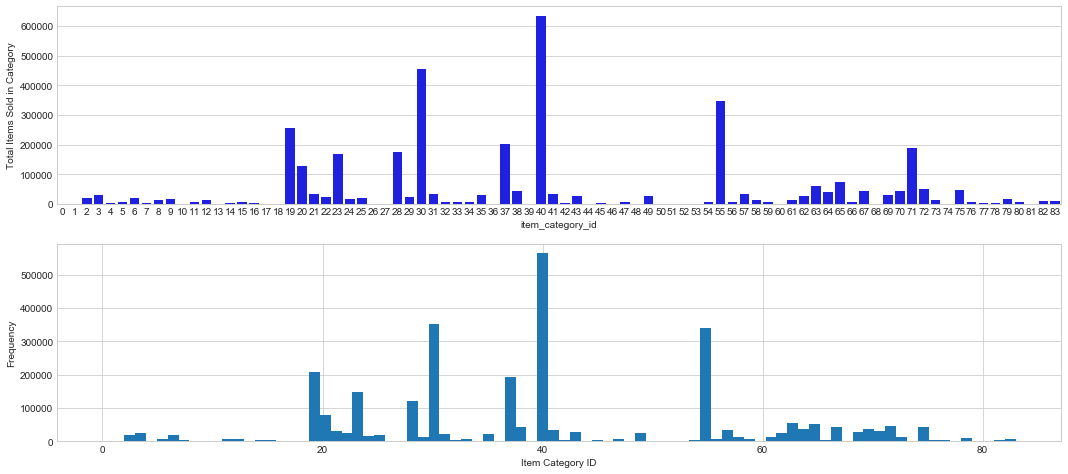

In [33]:
# Next we'll take a look at item_category_id
item_cat_df = training_merge_df.groupby('item_category_id')[['item_cnt_day']].sum()
item_cat_df.columns = ['Total Items Sold in Category']

# Define the subplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(18, 8))

# Plot the barplot
sns.barplot(x=item_cat_df.index, y=item_cat_df['Total Items Sold in Category'], color='b', ax=ax1)

# Plot the histogram
ax2.hist(training_merge_df['item_category_id'], bins=84)
ax2.set_xlabel('Item Category ID')
ax2.set_ylabel('Frequency')

# Both the histogram and the barplots appear similar. However, we see much larger discrepancies in the categories

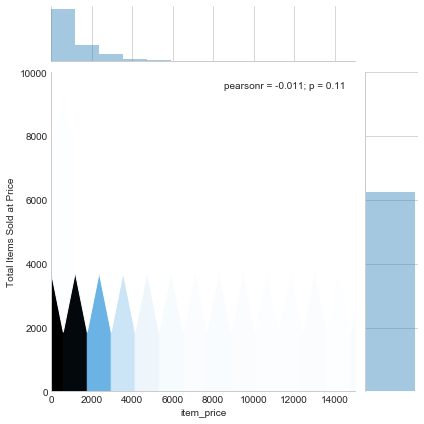

In [37]:
# Lastly we'll look at the effects of item_price
item_price_df = training_merge_df.groupby('item_price')[['item_cnt_day']].sum()
item_price_df.columns = ['Total Items Sold at Price']

# Plot the barplot
sns.jointplot(x=item_price_df.index, y=item_price_df['Total Items Sold at Price'], kind='hex', xlim=(0,15000), ylim=(0, 10000))

# The original plot has x-axis (0 - 70,000) and y-axis (0 - 300,000)
# We can see that sales being to decline drastically after item price 5000.

Text(0,0.5,'Frequency')

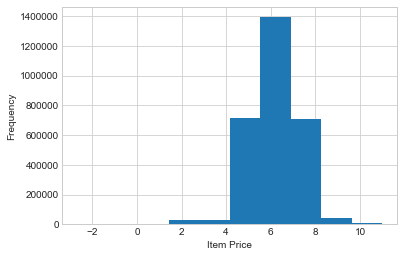

In [29]:
# Plot the histogram with a logarithmic scale
plt.hist(np.log(training_merge_df['item_price']))
plt.xlabel('Item Price')
plt.ylabel('Frequency')

# Interestingly enough, it looks most of the entries occur at approximate item_price = 403 (e ^ 6) and the distribution is 
# fairly normal around that point

Of all the variables explored here, it sems like item_price and month may be the best predictors of items sold. Although item_price doesn't have a significant correlation with items sold, it does tell us the price range where most purchases are generally made. 

For the shop_id and item_category_id, we can observe how some shops perform significantly better than others. This gives us the choice of grouping some of the lower performing shops/item categories together for our model. This also helps reduce the amount of dummy variables we'll need to work with which reduces the computational intensity.

Although we won't be exploring this in our analysis here, an interesting question to ask is the cause for the decline in sales. A hypothesis is that the data isn't continually updated with new items (ex. PS3s were popular in 2013, but not so much in the later years as more consoles arrived). Specific items could have also been removed from shop shelves which wouldn't be reflected in the provided data. This would suggest that the decline is sales could just be movement from one trend to the next. However, if that was the case, what drives the sales so much in December of every year? 

Similar questions can be asked about shop performance. Why do some shops perform so much better than others? We haven't personally seen any of the explored shops, but if a shop closed down within the 2.5 year timespan (which is common for smaller, local stores), we would see overall low performance in those shops.